# A simple analysis of FIDE top 100 rated players (as of october 2022)

## 01: Project overview

I'll be direct to the point this project was motivated because Hans cheat scandal 🤣. As I'm also curious about his hyper fast growth I decided to analyse myself and see if I can confirm the results I saw on articles and youtube.

First of all I'll explain the project structure (folder and files) and of course how you can run it yourself.
```txt
.
├── data
│   └── fide_top_players_2022_10.json
├── README.md
├── requirements.txt
├── src
│   ├── data
│   │   ├── fide_blitz_rating.csv
│   │   ├── fide_classical_rating.csv
│   │   ├── fide_players_info.csv
│   │   └── fide_rapid_rating.csv
│   ├── main.ipynb
│   └── plots
│       ├── road_to_super_gm
│       └── road_to_super_gm_diff
└── structure.txt

6 directories, 9 files
```

The project is kinda simple with only 6 folders and 9 files, now I'll give it a quick explanation about each one in a list format:

- data: Folder to hold data that wasn't generated by this project
    - fide_top_players_2022_10.json: Data in JSON format that holds all top players info and history
- README.md: Github page file
- requirements.txt: Project python dependencies
- src: All code developed and data generated in the project
    - data: Folder to hold data generated by this project
        - fide_blitz_rating.csv: Data in CSV format with top players blitz rating histories
        - fide_classical_rating.csv: Data in CSV format with top players classical rating histories
        - fide_players_info.csv: Data in CSV format with top players info
        - fide_rapid_rating.csv: Data in CSV format with top players rapid rating histories
    - main.ipynb: This notebook you are seeing right now 😉
    - plots: The folder name speaks for itself
        - road_to_super_gm: Folder containing the top players road to super GM
        - road_to_super_gm_diff: Folder containing the top players rating difference on this road
- structure.txt: The file that contains the project structure tree view


## 02: Getting the data

Working with FIDE oficial data is not simple, mainly because they don't have an API. That's the reason I made a simple API with FastAPI to scrape the data from their own website and provide it as JSON over HTTP requests.

For this analysis we already start with the file **fide_top_players_2022_10.json** in the data folder outside src folder. In the next cell, you will see the script I used to transform the JSON data to CSVs so that its easier (at least possible) to handle.

In [1]:
# First thing first, we will import all dependencies needed for this chapter

import orjson        # For parsing JSON to python objects
import numpy as np   # For fast list and math operations
import pandas as pd  # For working with dataframes amazing features

In [2]:
# Loading the JSON and transforming it on python objects

rating_json = open("../data/fide_top_players_2022_10.json", "r")

rating_data = orjson.loads(rating_json.read())

print(f"{rating_data}"[:300])

# Below is printed only first 300 character because the file is huge

[{'rank': '1', 'name': 'Carlsen, Magnus', 'fide_id': '1503014', 'title': 'g', 'country': 'NOR', 'rating': '2856', 'games': '3', 'birth_year': '1990', 'history': [{'period': '2022-Oct', 'classical_rating': '2856', 'classical_games': '3', 'rapid_rating': '2834', 'rapid_games': '0', 'blitz_rating': '28


Next we need to transform this big gathering of python objects in CSVs, below is the JSON structure so that you can understand (hopefully) the steps I made to achieve that.

```ts
interface IPlayerInfoWithHistory {
  rank: string;
  name: string;
  fide_id: string;
  title: string;
  country: string;
  rating: string;
  games: string;
  birth_year: string;
  history: IPlayerHistory[];
}

interface IPlayerHistory {
  period: string;
  classical_rating: string;
  classical_games: string;
  rapid_rating: string;
  rapid_games: string;
  blitz_rating: string;
  blitz_games: string;
  date: string;
}
```

In [3]:
# Transforming the rating_data dict to dataframe
players_info_df = pd.DataFrame(rating_data)

# Droping the history column because it has lot of nested data
players_info_df = players_info_df.drop(columns=["history"])

# Saving it to a nice and clean CSV file
players_info_df.to_csv("data/fide_players_info.csv", index=None)

# Printing some sample so that I'm sure I didn't messed up
players_info_df.head()

,rank,name,fide_id,title,country,rating,games,birth_year
0,1,"Carlsen, Magnus",1503014,g,NOR,2856,3,1990
1,2,"Ding, Liren",8603677,g,CHN,2811,9,1992
2,3,"Nepomniachtchi, Ian",4168119,g,RUS,2793,9,1990
3,4,"Firouzja, Alireza",12573981,g,FRA,2785,8,2003
4,5,"So, Wesley",5202213,g,USA,2774,8,1993


Now we will get to the most cool part that is transform all the top players histories in CSV files with the three time controls.

In [4]:
# Getting a list of all top players name
players_name = list(players_info_df["name"])

# The names and the date will be our dataframe columns
columns = ["Date", *players_name]

# Only for not using list.index all the time
column_index = {value: key for (key, value) in enumerate(columns)}

# The three time controls we want to analyse
time_controls = ["classical", "rapid", "blitz"]

# Looping in time controls
for time_control in time_controls:
    # As we are dealing with a nested thing we start with a empty matrix
    raw_data = np.empty((0,len(columns)), str)

    # Looping in all players
    for player in rating_data:
        # Player column index in matrix
        player_index = column_index[player["name"]]

        # Looping in each history entry
        for history in player["history"]:
            # Player rating at the desired time control
            player_rating = history[f"{time_control}_rating"]

            # Search if we already have the date previously else create a new row for it
            search_result = np.where(raw_data == history["date"])

            if len(search_result[0]) > 0:
                # Date row index
                date_index = search_result[0][0]

                # Putting rating in the right matrix position
                raw_data[date_index][player_index] = player_rating

            else:
                # Create a new array that supports up to 128 characters
                new_row = np.empty(len(columns), "<U128")

                # Putting the date as the first info in the row
                new_row[0] = history["date"]

                # Putting the rate below the right player
                new_row[player_index] = player_rating

                # Putting the new row into the matrix
                raw_data = np.vstack([raw_data, new_row])

    # Making a dataframe with the created frankenstein
    player_histories_df = pd.DataFrame(raw_data, columns=columns)

    # Making the date as our index column
    player_histories_df = player_histories_df.set_index("Date")

    # Replacing empty strings as real empty values
    player_histories_df = player_histories_df.replace("", None)

    # Droping dates that doesn't have any rating recorded
    player_histories_df = player_histories_df.dropna(axis=0, how="all")

    # Saving all the work in a nice and clean CSV file
    player_histories_df.to_csv(f"data/fide_{time_control}_rating.csv")

In [5]:
fide_classical_rating = pd.read_csv("data/fide_classical_rating.csv", index_col="Date")

fide_classical_rating.head()

# Just making sure I did the cell above right

,"Carlsen, Magnus","Ding, Liren","Nepomniachtchi, Ian","Firouzja, Alireza","So, Wesley","Nakamura, Hikaru","Giri, Anish","Caruana, Fabiano","Anand, Viswanathan","Aronian, Levon",...,"McShane, Luke J","Swiercz, Dariusz","Berkes, Ferenc","Grandelius, Nils","Malakhov, Vladimir","Bluebaum, Matthias","Bacrot, Etienne","Donchenko, Alexander","Abasov, Nijat","Mamedov, Rauf"
Date,,,,,,,,,,,,,,,,,,,,,
2022-10,2856.0,2811.0,2793.0,2785.0,2774.0,2768,2764.0,2763.0,2756,2755,...,2653,2652.0,2651,2651.0,2651,2647.0,2646,2646.0,2646.0,2646.0
2022-09,2861.0,2808.0,2792.0,2778.0,2771.0,2768,2764.0,2758.0,2756,2759,...,2650,2652.0,2651,2651.0,2651,2647.0,2647,2639.0,2646.0,2646.0
2022-08,2864.0,2808.0,2792.0,2778.0,2773.0,2768,2760.0,2776.0,2756,2775,...,2661,2652.0,2649,2655.0,2651,2664.0,2648,2630.0,2633.0,2656.0
2022-07,2864.0,2806.0,2766.0,2793.0,2773.0,2760,2760.0,2783.0,2756,2775,...,2649,2652.0,2649,2655.0,2651,2673.0,2656,2640.0,2633.0,2656.0
2022-06,2864.0,2806.0,2766.0,2793.0,2775.0,2760,2761.0,2783.0,2751,2775,...,2649,2652.0,2654,2645.0,2652,2673.0,2641,2602.0,2635.0,2656.0


## 03: Analysing the data

The main goal of this analysis is to anwser the questions bellow. They will be discussed later in the conclusion.

- How fast top players grow in different time controls?
    - Does Hans show a strange growth?
- How much close are top players in different time controls?
    - Does Hans show a strange rating variantion among other time controls?

### 03.1: Growth Analysis

After handling the data we can finally start with the analysis, our objective here is to find patterns on top players natural growth and compare it with Hans. We will crop Magnus Carlsen (chess world champion) from 2500 to 2699 rating (period to become a GM until the highest rating a GM can get, after that the player becomes a super GM).

In [6]:
# Now we will import all ratings data
fide_classical_rating = pd.read_csv("data/fide_classical_rating.csv", index_col="Date")

# Sorting by date in ascending order
fide_classical_rating_ascending = fide_classical_rating.sort_index()

# We want to analyse
magnus_carlsen_rating = fide_classical_rating_ascending["Carlsen, Magnus"]

# His way to glory
magnus_carlsen_becoming_super_gm = magnus_carlsen_rating[
    (2500 < magnus_carlsen_rating) & (magnus_carlsen_rating < 2700)
]

magnus_carlsen_becoming_super_gm = pd.DataFrame(magnus_carlsen_becoming_super_gm)
magnus_carlsen_becoming_super_gm.columns = ["Classical rating"]

magnus_carlsen_becoming_super_gm.head()

,Classical rating
Date,
2004-04,2552.0
2004-07,2567.0
2004-10,2581.0
2005-01,2553.0
2005-04,2548.0


In [7]:
# Bellow are 2 helper function for calculating month diff
# It will be used on the next cells

def month_diff(start_date: str, end_date: str):
    start_year = int(start_date.split("-")[0])
    start_month = int(start_date.split("-")[1])

    end_year = int(end_date.split("-")[0])
    end_month = int(end_date.split("-")[1])
    
    year_diff = end_year - start_year
    month_diff = end_month - start_month
    
    total_diff = year_diff * 12 + month_diff
    
    return total_diff

def date_array_month_diff(date_array):
    start_date = date_array[0]
    end_date = date_array[-1]
    
    return month_diff(start_date, end_date)

Now that we got the data, we plot the data

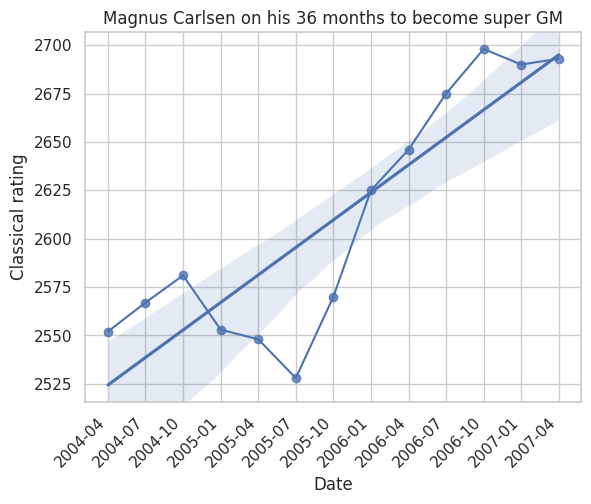

In [8]:
import seaborn as sns # For plotting

sns.set_theme(style="whitegrid") # Nice grid

import matplotlib.pyplot as plt # For tweaking

numerical_x = pd.Series(range(len(magnus_carlsen_becoming_super_gm.index)))

sns.regplot(
    x=numerical_x,
    y="Classical rating",
    data=magnus_carlsen_becoming_super_gm,
)

ax = sns.lineplot(magnus_carlsen_becoming_super_gm, legend=False)

months_taken = date_array_month_diff(magnus_carlsen_becoming_super_gm.index)

ax.set_title(f"Magnus Carlsen on his {months_taken} months to become super GM")

plt.xticks(
    rotation=45, 
    horizontalalignment='right',
)

plt.show()

plt.clf()
plt.close()

The plot above show us lot of things, Magnus way to super GM (even though he is the G.O.A.T.) was not even close to easy at all, with a lot of highs and lows and that he took 36 months on GM road. Well, now that we made this beautiful plot we will make a loop so that it plots all the top players. Of course I won't show them all in this notebook, but the generated plot will be on the src/plots folder. It's important to notice that even he struggled a lot on 2500 to 2600 rating. As we are looping into all the data we'll record some key info like the start and the end of the road to super GM.

In [9]:
roads_to_super_gm = pd.DataFrame(columns=["name", "time_control", "start_date", "end_date", "months_taken"])

for time_control in time_controls:
    fide_rating = pd.read_csv(f"data/fide_{time_control}_rating.csv", index_col="Date")

    fide_rating_ascending = fide_rating.sort_index()

    for player_name in players_name:
        player_history = fide_rating_ascending[player_name]

        highest_rating = player_history.max()
        lowest_rating = player_history.min()

        if highest_rating < 2699: continue

        if lowest_rating > 2499: continue

        becoming_super_gm = []
        never_super_gm = True
        for rating in player_history:
            if rating > 2699: never_super_gm = False

            becoming_super_gm.append(never_super_gm and rating > 2499)

        if sum(becoming_super_gm) == 0: continue

        player_becoming_super_gm = player_history[becoming_super_gm]

        player_becoming_super_gm = pd.DataFrame(player_becoming_super_gm)

        y_name = f"{time_control} rating"

        player_becoming_super_gm.columns = [y_name]

        numerical_x = pd.Series(range(len(player_becoming_super_gm.index)))
        
        plt.figure(figsize=(11, 7), dpi=80)

        sns.regplot(
            x=numerical_x,
            y=y_name,
            data=player_becoming_super_gm,
        )

        ax = sns.lineplot(player_becoming_super_gm, legend=False)

        months_taken = date_array_month_diff(player_becoming_super_gm.index)

        ax.set_title(f"({player_name}) on his {months_taken} months to become {time_control} super GM")

        plt.xticks(
            rotation=45, 
            horizontalalignment='right',
        )

        plt.savefig(f"plots/road_to_super_gm/{player_name} on the {time_control} GM road.png")

        plt.clf()
        plt.close()

        road_to_super_gm_info = pd.Series({
            "name": player_name,
            "time_control": time_control,
            "start_date": player_becoming_super_gm.index[0],
            "end_date": player_becoming_super_gm.index[-1],
            "months_taken": months_taken,
        })

        roads_to_super_gm = pd.concat([roads_to_super_gm, road_to_super_gm_info.to_frame().T], ignore_index=True)

roads_to_super_gm.head()

,name,time_control,start_date,end_date,months_taken
0,"Carlsen, Magnus",classical,2004-04,2007-04,36
1,"Ding, Liren",classical,2009-07,2012-09,38
2,"Nepomniachtchi, Ian",classical,2005-04,2010-05,61
3,"Firouzja, Alireza",classical,2017-08,2019-07,23
4,"So, Wesley",classical,2007-04,2013-02,70


After generating all the plots and saving the key data for futher analysis we can finally see who was the player that went from 2500 to 2699 the faster!

In [10]:
roads_to_super_gm_ordered_by_months_taken = roads_to_super_gm.sort_values("months_taken")

roads_to_super_gm_ordered_by_months_taken = roads_to_super_gm_ordered_by_months_taken[
    roads_to_super_gm_ordered_by_months_taken["end_date"] > "2004-12"
]

roads_to_super_gm_ordered_by_months_taken.head()

,name,time_control,start_date,end_date,months_taken
61,"Firouzja, Alireza",rapid,2019-01,2019-12,11
73,"Dubov, Daniil",blitz,2012-03,2013-06,15
70,"Maghsoodloo, Parham",blitz,2016-08,2018-03,19
33,"Niemann, Hans Moke",classical,2021-02,2022-10,20
3,"Firouzja, Alireza",classical,2017-08,2019-07,23


Looking at some sample, we can see that Firuzja is a monster XD, but in this tiny sample we already spot all objective (Hans Moke Niemann), let's see if a bit of plotting can help us more.

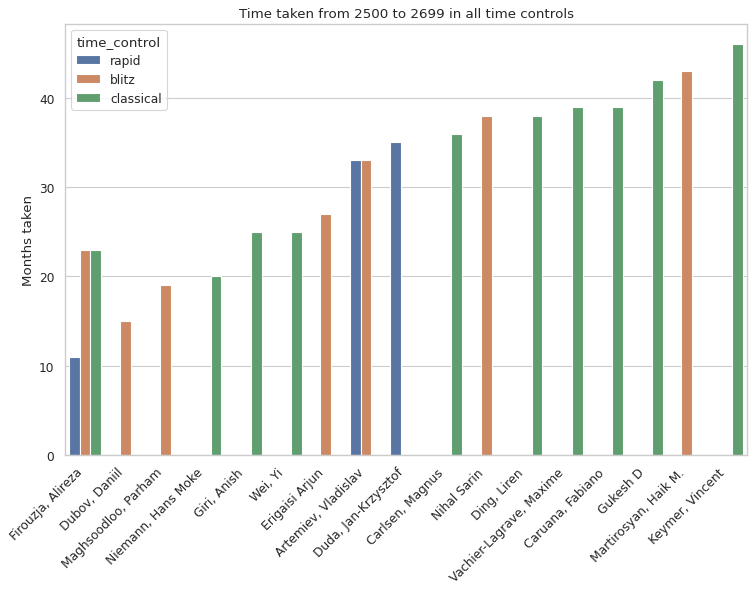

In [11]:
plt.figure(figsize=(11, 7), dpi=80)

ax = sns.barplot(
    data=roads_to_super_gm_ordered_by_months_taken.head(20),
    x="name",
    y="months_taken",
    hue="time_control",
)

ax.set(xlabel="", ylabel="Months taken")

ax.set_title("Time taken from 2500 to 2699 in all time controls")

plt.xticks(
    rotation=45, 
    horizontalalignment='right',
)

plt.show()

plt.clf()
plt.close()

Besides showing that Firouzja is a monster again, this graph shows that Hans was the only one to go from 2500 to 2699 in this little time in the classical format, but to be sure we'll plot again with only classical results.

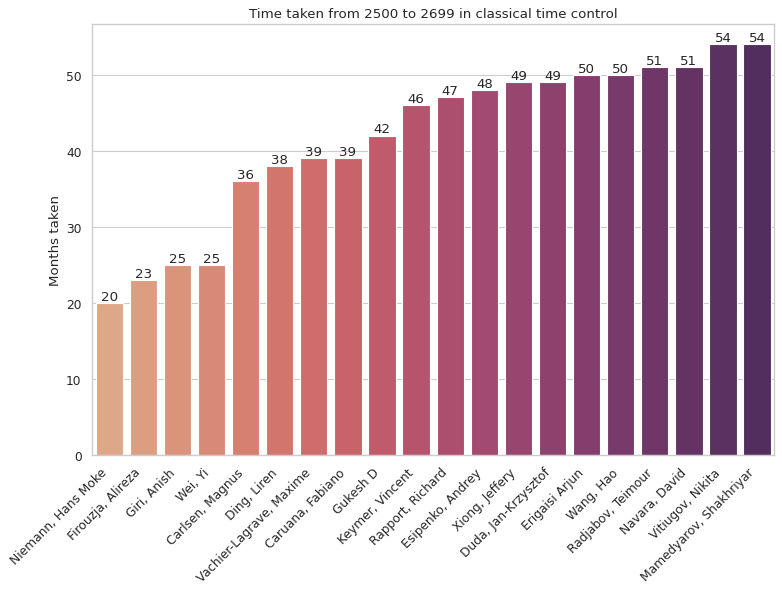

In [12]:
plt.figure(figsize=(11, 7), dpi=80)

classical_roads_to_super_gm_ordered_by_months_taken = roads_to_super_gm_ordered_by_months_taken[
    roads_to_super_gm_ordered_by_months_taken["time_control"] == "classical"
]

ax = sns.barplot(
    data=classical_roads_to_super_gm_ordered_by_months_taken.head(20),
    x="name",
    y="months_taken",
    palette="flare",
)

ax.set(xlabel="", ylabel="Months taken")

ax.set_title("Time taken from 2500 to 2699 in classical time control")

plt.xticks(
    rotation=45, 
    horizontalalignment='right',
)

ax.bar_label(ax.containers[0])

plt.show()

plt.clf()
plt.close()

Now we can already see Magnus Calrsen and some top players (Fabiano Caruana, Ding Liren, Giri and etc...). With this info we can also conclude that only 4 players achieved this growth speed (Hans, Firouzja, Giri and Wei Yi) and Hans is the cream of the crop. Bellow all do boths graphs again but in super size and put it on plot folder so we can see all the players.

In [13]:
plt.figure(figsize=(49, 7), dpi=80)

ax = sns.barplot(
    data=roads_to_super_gm_ordered_by_months_taken,
    x="name",
    y="months_taken",
    hue="time_control",
)

ax.set(xlabel="", ylabel="Months taken")

ax.set_title("Time taken from 2500 to 2699 in all time controls")

plt.xticks(
    rotation=45, 
    horizontalalignment='right',
)

plt.savefig("plots/2500_to_2699_all_time_controls.png", bbox_inches = "tight")

plt.clf()
plt.close()

In [14]:
plt.figure(figsize=(49, 7), dpi=80)

classical_roads_to_super_gm_ordered_by_months_taken = roads_to_super_gm_ordered_by_months_taken[
    roads_to_super_gm_ordered_by_months_taken["time_control"] == "classical"
]

ax = sns.barplot(
    data=classical_roads_to_super_gm_ordered_by_months_taken,
    x="name",
    y="months_taken",
    palette="flare",
)

ax.set(xlabel="", ylabel="Months taken")

ax.set_title("Time taken from 2500 to 2699 in classical time control")

ax.bar_label(ax.containers[0])

plt.xticks(
    rotation=45, 
    horizontalalignment='right',
)

plt.savefig("plots/2500_to_2699_classical_time_control.png", bbox_inches = "tight")

plt.close()

For our last plot, we'll check at what ages top players achieve 2699 rating.

In [15]:
player_info = pd.read_csv("data/fide_players_info.csv")

top_player_ages = []
months_takens = []

for (player, birth_year) in zip(player_info["name"], player_info["birth_year"]):
    end_date_series = roads_to_super_gm[
        (roads_to_super_gm["time_control"] == "classical") &
        (roads_to_super_gm["name"] == player)
    ]["end_date"]

    if len(end_date_series) == 0:
        top_player_ages.append(None)
        months_takens.append(None)
        continue
    
    end_year = int(end_date_series.iloc[0].split("-")[0])

    top_player_age = end_year - birth_year

    top_player_ages.append(top_player_age)
    
    months_taken = roads_to_super_gm[
        (roads_to_super_gm["time_control"] == "classical") &
        (roads_to_super_gm["name"] == player)
    ]["months_taken"].iloc[0]
    
    months_takens.append(months_taken)

player_info["top_player_age"] = top_player_ages

player_info["years_taken"] = pd.Series(months_takens) / 12

player_info["age_per_years_taken"] = (player_info["top_player_age"] / player_info["years_taken"]).round(2)

player_info = player_info.dropna()

player_info = player_info.sort_values("top_player_age")

player_info.head()

,rank,name,fide_id,title,country,rating,games,birth_year,top_player_age,years_taken,age_per_years_taken
17,18,Gukesh D,46616543,g,IND,2732,7,2006,16.0,3.500000,4.57
23,24,"Wei, Yi",8603405,g,CHN,2722,6,1999,16.0,2.083333,7.68
3,4,"Firouzja, Alireza",12573981,g,FRA,2785,8,2003,16.0,1.916667,8.35
14,15,"Karjakin, Sergey",14109603,g,RUS,2747,0,1990,17.0,5.250000,3.24
6,7,"Giri, Anish",24116068,g,NED,2764,0,1994,17.0,2.083333,8.16


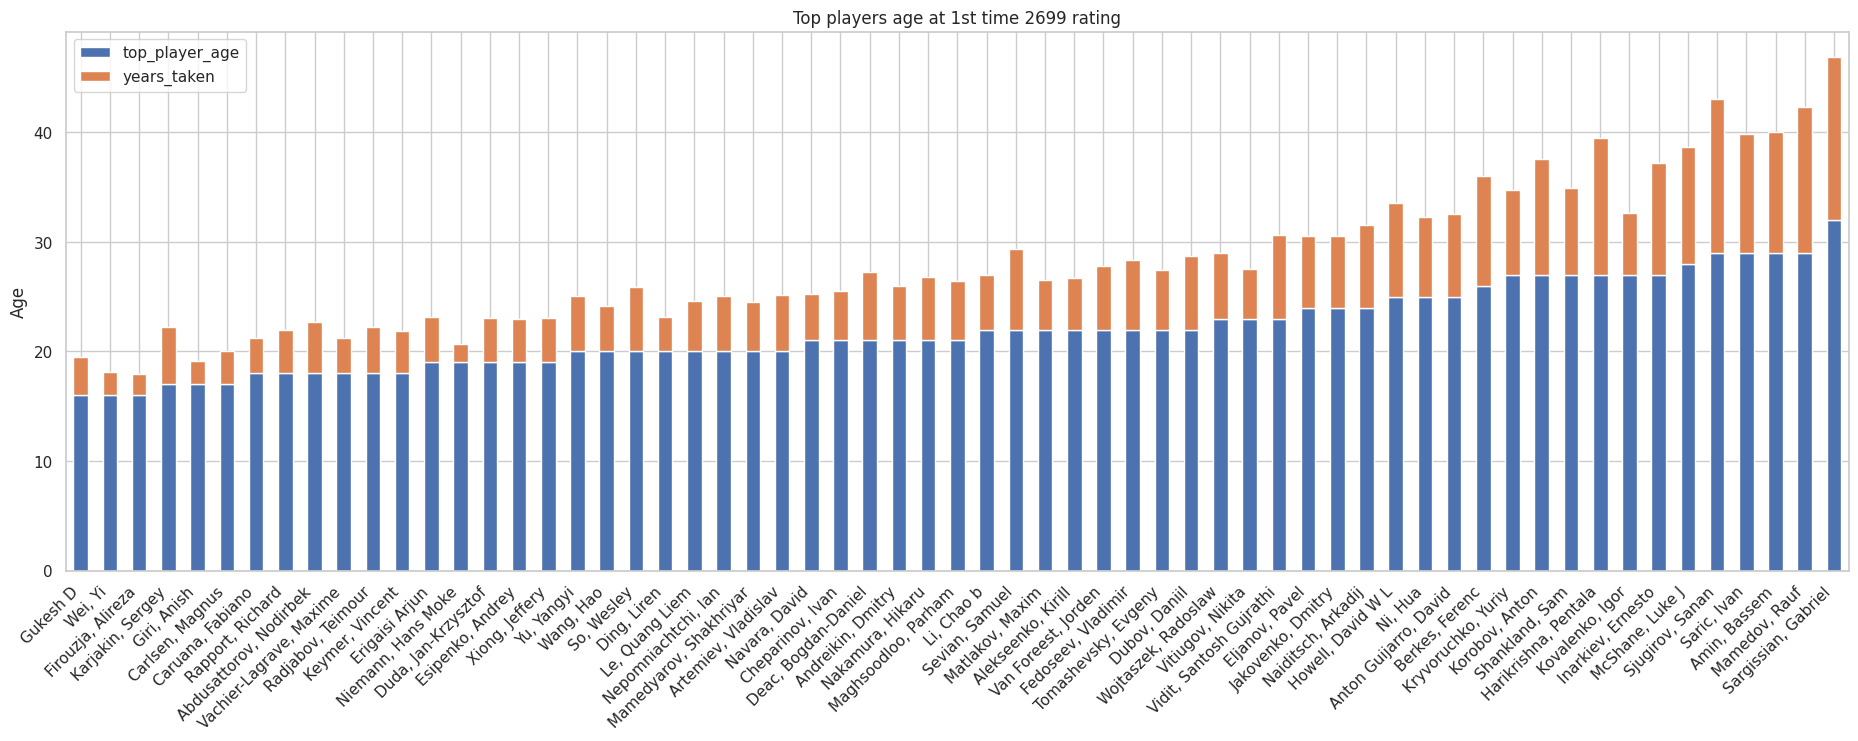

In [16]:
ax = player_info.plot.bar(
    stacked=True,
    y=["top_player_age", "years_taken"],
    x="name",
    figsize=(23, 7),
)

ax.set(xlabel="", ylabel="Age")

ax.set_title("Top players age at 1st time 2699 rating")

plt.xticks(
    rotation=45, 
    horizontalalignment='right',
)

plt.savefig("plots/fide_first_time_2699_age.png", bbox_inches = "tight")

plt.show()

plt.clf()
plt.close()

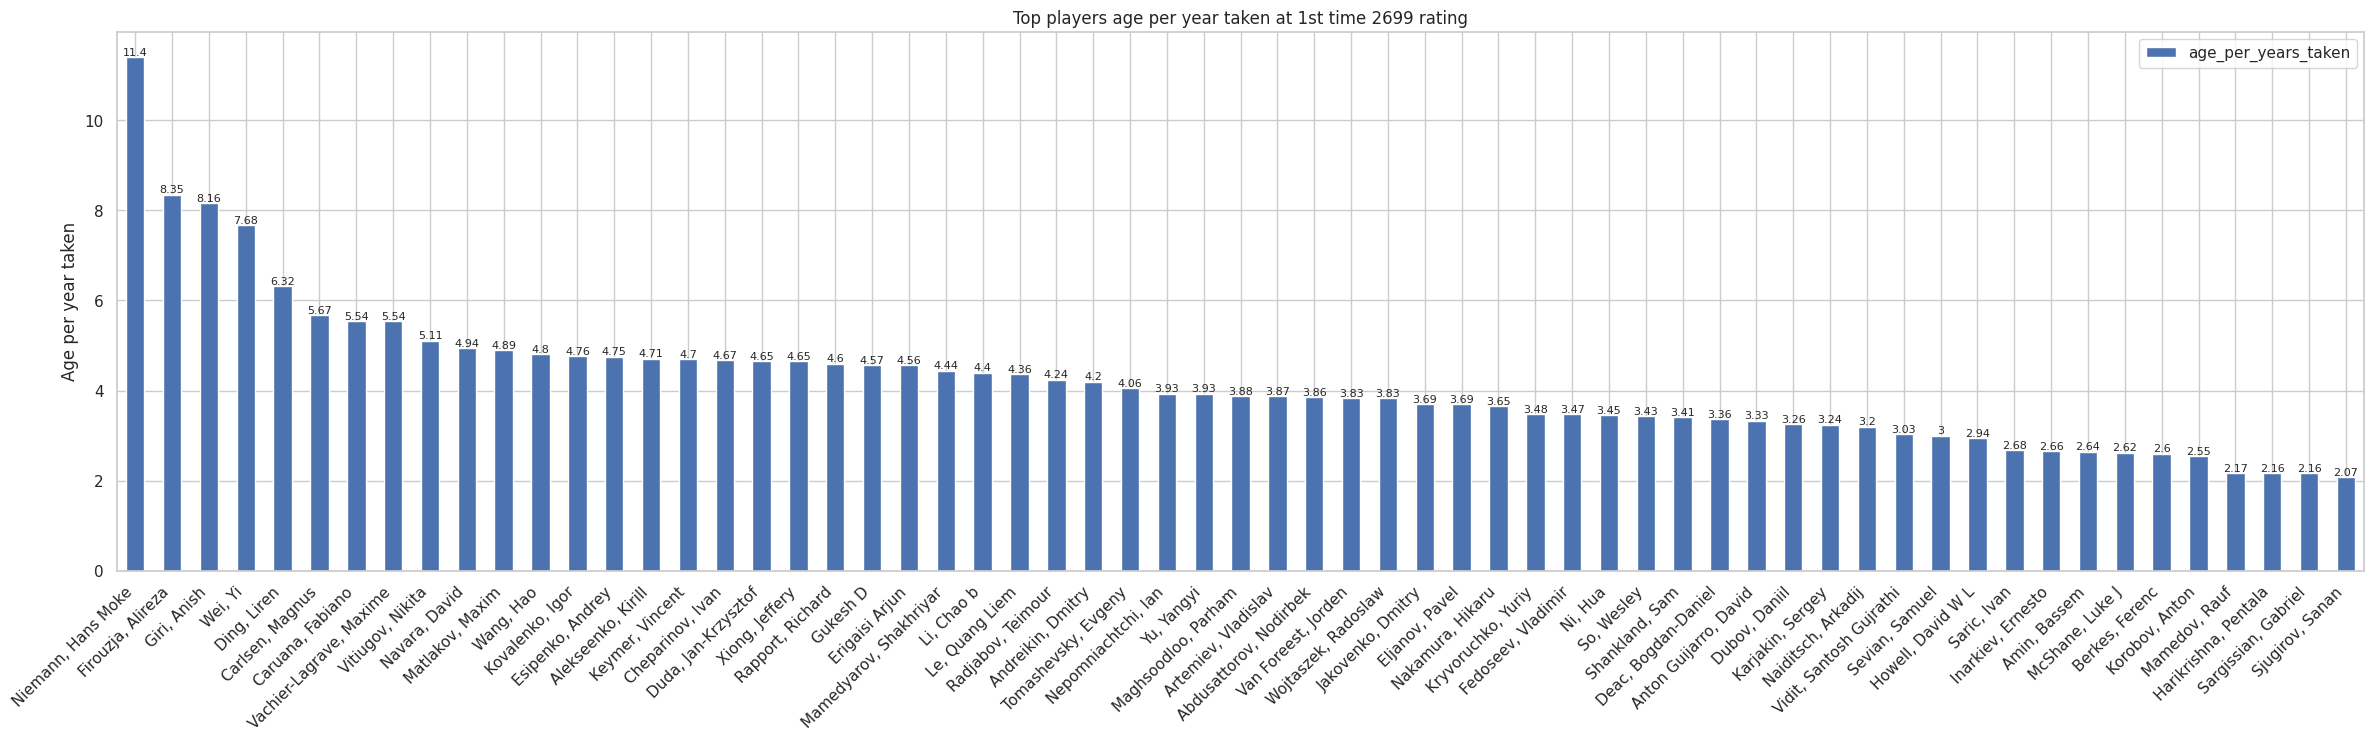

In [17]:
ax = player_info.sort_values("age_per_years_taken", ascending=False).plot.bar(
    y="age_per_years_taken",
    x="name",
    figsize=(29, 7),
)

ax.set(xlabel="", ylabel="Age per year taken")

ax.set_title("Top players age per year taken at 1st time 2699 rating")

ax.bar_label(ax.containers[0], fontsize=8)

plt.xticks(
    rotation=45, 
    horizontalalignment='right',
)

plt.savefig("plots/fide_first_time_2699_age_per_year_taken.png", bbox_inches = "tight")

plt.show()

plt.clf()
plt.close()

### 03.2: Time control analysis

After analysing the top players growth, it's time to anylisis they rating in different time controls.

In [18]:
fide_classical_rating = pd.read_csv(f"data/fide_classical_rating.csv", index_col="Date")
fide_rapid_rating = pd.read_csv(f"data/fide_rapid_rating.csv", index_col="Date")
fide_blitz_rating = pd.read_csv(f"data/fide_blitz_rating.csv", index_col="Date")

fide_classical_rating_ascending = fide_classical_rating.sort_index()
fide_rapid_rating_ascending = fide_rapid_rating.sort_index()
fide_blitz_rating_ascending = fide_blitz_rating.sort_index()

fide_classical_rapid_diff = abs(fide_classical_rating_ascending - fide_rapid_rating_ascending)
fide_classical_blitz_diff = abs(fide_classical_rating_ascending - fide_blitz_rating_ascending)
fide_rapid_blitz_diff = abs(fide_rapid_rating_ascending - fide_blitz_rating_ascending)

fide_rating_mean_diff = (fide_classical_rapid_diff + fide_classical_blitz_diff + fide_rapid_blitz_diff) / 3

fide_rating_mean_diff.tail()

,"Carlsen, Magnus","Ding, Liren","Nepomniachtchi, Ian","Firouzja, Alireza","So, Wesley","Nakamura, Hikaru","Giri, Anish","Caruana, Fabiano","Anand, Viswanathan","Aronian, Levon",...,"McShane, Luke J","Swiercz, Dariusz","Berkes, Ferenc","Grandelius, Nils","Malakhov, Vladimir","Bluebaum, Matthias","Bacrot, Etienne","Donchenko, Alexander","Abasov, Nijat","Mamedov, Rauf"
Date,,,,,,,,,,,,,,,,,,,,,
2022-06,21.333333,32.000000,54.000000,82.000000,24.666667,60.000000,24.000000,54.000000,15.333333,81.333333,...,74.0,16.666667,25.333333,23.333333,12.000000,78.000000,52.666667,20.666667,71.333333,54.666667
2022-07,24.000000,32.000000,54.000000,82.000000,10.666667,60.000000,32.666667,54.000000,16.666667,81.333333,...,74.0,16.666667,25.333333,25.333333,12.666667,78.000000,42.666667,46.000000,70.000000,54.666667
2022-08,22.666667,32.000000,2.666667,60.666667,14.000000,54.666667,47.333333,54.000000,16.666667,81.333333,...,74.0,16.666667,35.333333,25.333333,12.666667,51.333333,48.000000,38.666667,70.000000,54.666667
2022-09,20.666667,32.000000,8.666667,42.000000,14.000000,54.666667,47.333333,66.666667,16.666667,86.666667,...,74.0,16.666667,35.333333,23.333333,12.666667,40.000000,48.000000,44.666667,78.666667,54.666667
2022-10,17.333333,27.333333,18.000000,105.333333,14.000000,94.000000,47.333333,66.666667,16.666667,59.333333,...,74.0,20.000000,35.333333,23.333333,12.666667,20.000000,48.666667,49.333333,66.666667,54.666667


Now that we have all differences we'll check it on the growth period for each player and make a plot for each one. First we'll see the difference between the classical and rapid ratings. Some players don't have rapid or blitz rating on their growth period so we'll just skip then.

In [19]:
for player_name in players_name:
    player_all_rating_and_diffs = pd.DataFrame(index=fide_classical_rating_ascending.index)

    player_all_rating_and_diffs["classical_rating"] = fide_classical_rating_ascending[player_name]
    player_all_rating_and_diffs["rapid_rating"] = fide_rapid_rating_ascending[player_name]
    player_all_rating_and_diffs["blitz_rating"] = fide_blitz_rating_ascending[player_name]

    player_all_rating_and_diffs["classical_rapid_diff"] = fide_classical_rapid_diff[player_name]
    player_all_rating_and_diffs["classical_blitz_diff"] = fide_classical_blitz_diff[player_name]
    player_all_rating_and_diffs["rapid_blitz_diff"] = fide_rapid_blitz_diff[player_name]

    player_all_rating_and_diffs["mean_diff"] = fide_rating_mean_diff[player_name]

    player_all_rating_and_diffs = player_all_rating_and_diffs.fillna(0)
    
    classical_start_date_series = roads_to_super_gm_ordered_by_months_taken.loc[
        (roads_to_super_gm_ordered_by_months_taken["name"] == player_name) &
        (roads_to_super_gm_ordered_by_months_taken["time_control"] == "classical")
    ]["start_date"]
    
    classical_end_date_series = roads_to_super_gm_ordered_by_months_taken.loc[
        (roads_to_super_gm_ordered_by_months_taken["name"] == player_name) &
        (roads_to_super_gm_ordered_by_months_taken["time_control"] == "classical")
    ]["end_date"]
    
    if len(classical_start_date_series) == 0: continue
    if len(classical_end_date_series) == 0: continue
    
    classical_start_date = classical_start_date_series.iloc[0]

    classical_end_date = classical_end_date_series.iloc[0]

    player_all_rating_and_diffs = player_all_rating_and_diffs[
        (player_all_rating_and_diffs.index >= classical_start_date) &
        (player_all_rating_and_diffs.index <= classical_end_date)
    ]
    
    if player_all_rating_and_diffs.min().min() == 0: continue

    plt.figure(figsize=(17, 7), dpi=80)

    ax = sns.lineplot(player_all_rating_and_diffs[[
        "classical_rating",
        "rapid_rating",
        "blitz_rating",
    ]], legend=True)

    ax.set_title(f"({player_name}) on his way to super GM")

    plt.xticks(
        rotation=45, 
        horizontalalignment='right',
    )

    plt.savefig(f"plots/road_to_super_gm_diff/{player_name} ratings.png")

    plt.clf()
    plt.close()

    plt.figure(figsize=(17, 7), dpi=80)

    ax = sns.lineplot(player_all_rating_and_diffs[[
        "classical_rapid_diff",
        "classical_blitz_diff",
        "rapid_blitz_diff",
        "mean_diff",
    ]], legend=True)

    ax.set_title(f"({player_name}) on his way to super GM")

    plt.xticks(
        rotation=45, 
        horizontalalignment='right',
    )

    plt.savefig(f"plots/road_to_super_gm_diff/{player_name} diffs.png")

    plt.clf()
    plt.close()

Now that we have all plots (they'll be showed in the conclusion) we can see the rating difference from all top players and compare it with Hans.

In [20]:
fide_last_classical_rating = fide_classical_rating.iloc[0]
fide_last_rapid_rating = fide_rapid_rating.iloc[0]
fide_last_blitz_rating = fide_blitz_rating.iloc[0]

fide_last_ratings = fide_last_classical_rating.to_frame().reset_index()

fide_last_ratings.columns= ["name", "classical_rating"]

fide_last_ratings["rapid_rating"] = fide_last_rapid_rating.to_list()

fide_last_ratings["blitz_rating"] = fide_last_blitz_rating.to_list()

fide_last_ratings["classical_rapid_diff"] = abs(fide_last_ratings["classical_rating"] - fide_last_ratings["rapid_rating"])

fide_last_ratings["classical_blitz_diff"] = abs(fide_last_ratings["classical_rating"] - fide_last_ratings["blitz_rating"])

fide_last_ratings["rapid_blitz_diff"] = abs(fide_last_ratings["rapid_rating"] - fide_last_ratings["blitz_rating"])

fide_last_ratings["mean_diff"] = ((fide_last_ratings["classical_rapid_diff"] + fide_last_ratings["classical_blitz_diff"] + fide_last_ratings["rapid_blitz_diff"]) / 3).round(2)

fide_last_ratings.describe()

,classical_rating,rapid_rating,blitz_rating,classical_rapid_diff,classical_blitz_diff,rapid_blitz_diff,mean_diff
count,102.000000,102.000000,102.000000,102.000000,102.000000,102.000000,102.000000
mean,2697.098039,2658.892157,2665.764706,51.029412,57.549020,48.245098,52.275196
std,40.902809,66.306206,79.560697,32.102082,34.792063,39.908419,22.507385
min,2646.000000,2554.000000,2546.000000,0.000000,0.000000,0.000000,6.000000
25%,2666.250000,2614.500000,2609.000000,26.250000,26.250000,16.250000,33.335000
50%,2687.500000,2645.000000,2647.500000,44.000000,55.500000,35.000000,57.000000
75%,2721.750000,2708.250000,2708.000000,77.000000,89.500000,71.750000,66.670000
max,2856.000000,2834.000000,2909.000000,100.000000,141.000000,170.000000,113.330000


Now that we have all differences of the last rating from FIDE (as october 2022) we can plot it all 😄.

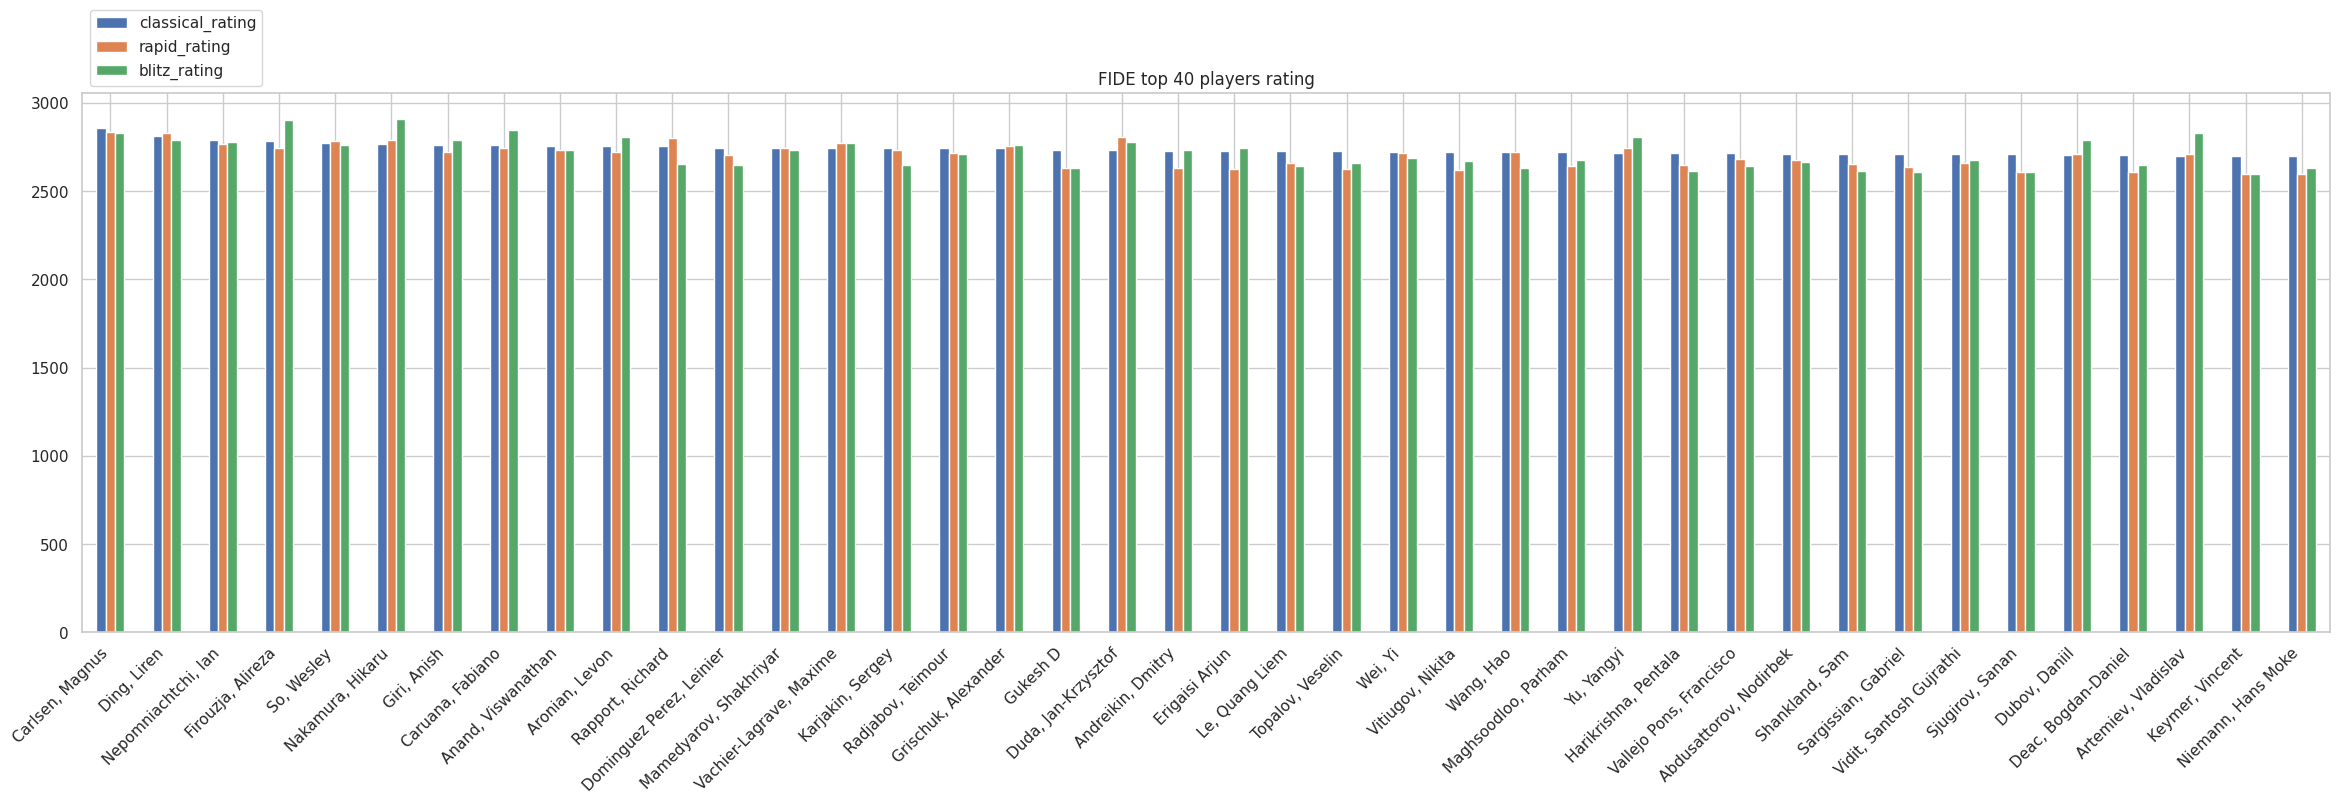

In [21]:
fide_last_ratings.head(40).plot(
    x="name",
    y=["classical_rating", "rapid_rating", "blitz_rating"],
    kind="bar",
    xlabel="",
    title="FIDE top 40 players rating",
    figsize=(29, 7),
)

plt.xticks(
    rotation=45, 
    horizontalalignment='right',
)

plt.legend(loc="lower left", bbox_to_anchor=(0,1.0))

plt.savefig("plots/fide_top_40_players_ratings.png", bbox_inches = "tight")

plt.show()

plt.clf()
plt.close()

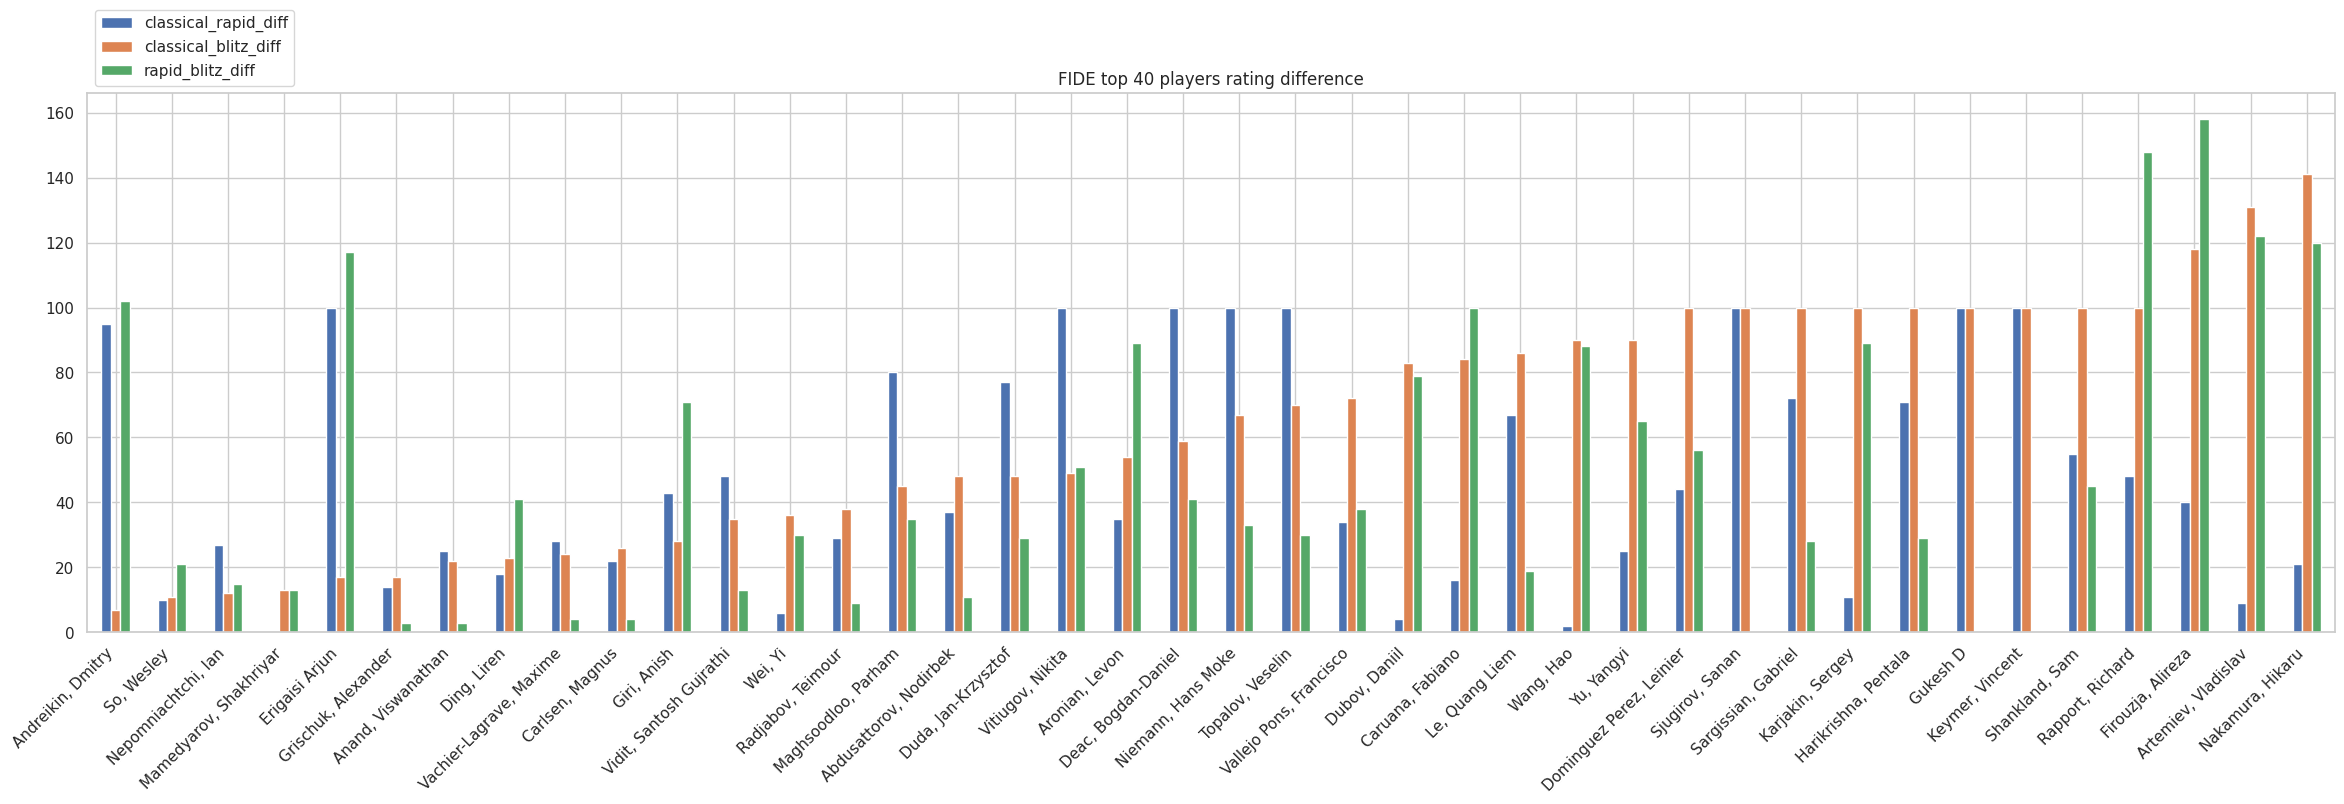

In [22]:
fide_last_ratings.head(40).sort_values("classical_blitz_diff").plot(
    x="name",
    y=["classical_rapid_diff", "classical_blitz_diff", "rapid_blitz_diff"],
    kind="bar",
    xlabel="",
    title="FIDE top 40 players rating difference",
    figsize=(29, 7),
)

plt.xticks(
    rotation=45, 
    horizontalalignment='right',
)

plt.legend(loc="lower left", bbox_to_anchor=(0,1.0))

plt.savefig("plots/fide_top_40_players_ratings_diff.png", bbox_inches = "tight")

plt.show()

plt.clf()
plt.close()

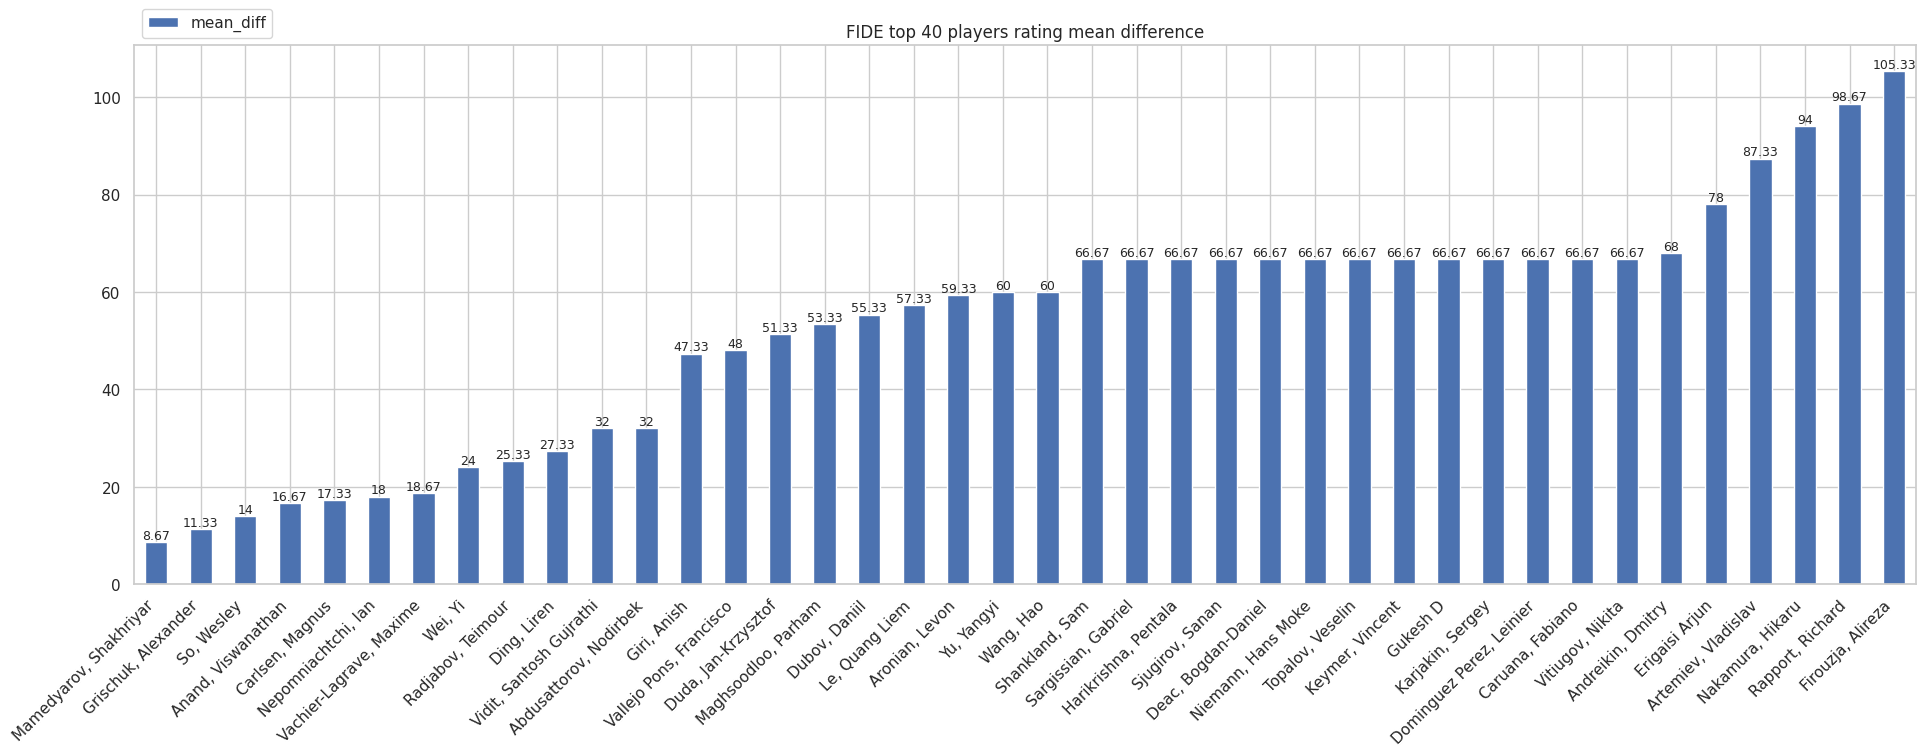

In [23]:
ax = fide_last_ratings.head(40).sort_values("mean_diff").plot(
    x="name",
    y=["mean_diff"],
    kind="bar",
    xlabel="",
    title="FIDE top 40 players rating mean difference",
    figsize=(23, 7),
)

ax.bar_label(ax.containers[0], fontsize=9)

plt.xticks(
    rotation=45, 
    horizontalalignment='right',
)

plt.legend(loc="lower left", bbox_to_anchor=(0,1.0))

plt.savefig("plots/fide_top_40_players_ratings_mean_diff.png", bbox_inches = "tight")

plt.show()

plt.clf()
plt.close()

## 4: Conclusion

Now we can go back to our goal questions:

- How fast top players grow in different time controls?
    - Does Hans show a strange growth?
- How much close are top players in different time controls?
    - Does Hans show a strange rating variantion among other time controls?

### 4.1: How fast top players grow in different time controls?

Besides the first players Hans, Firouzja, Giri and Wei Yi all top players (including Carlsen) took more than 30 months to achieve 2699 rating.

### 4.2: Does Hans show a strange growth?

Yes. Well, the data speak for itself (🤣). Jokes apart, even though he is the first, he is close to Firouzja, Giri and Wei Yi, but when we also look at their date we can obviously see that Hans has a huge value even compared to the cream of the crop.

### 4.3:  How much close are top players in different time controls?

 Even though we are dealing with 3 ratings for some kind of lucky a lot of players have the same mean difference of $66.6\overline{6}$, but the mean difference is $52.2$.

### 4.4: Does Hans show a strange rating variantion among other time controls?

No. I expected his ratings (mainly classical and blitz) to be far apart because of engine using but that was not the case, it's the most commom rating variation and Firouzja has one of the highest variantions (but the blitz timing is the higher one).

### 4.5: Personal Opinion

His rating growth is so strange that I don't think it's natural. I can only see 2 possibilities:

1. Hans is the greatest chess genius
2. Hans is somehow cheating

I believe the second one is the truth and we need to get him red handed because until there he is inocent.